In [ ]:
# Prepared feature data for xgboost classification model by merging with adopted user calculation from user engagement table.
#Added a column for 'Inviter' and 'Count Invites' to flag users that invite other users.  Used Get-dummies to convert creation
#source and org_id columns to classification columns.

#Ran XGBoost on resulting dataframe to get 87% accuracy predicting adopted users ("retained").  Shap values at the bottom
#show three big predictive features groups: Creation sources PERSONAL PROJECTS, GUEST INVITES, and GOOGLE AUTH, 
#count of users invited by a user, and a couple of org_id 0, 1 and 3.

#Relax Inc, may do well to consider users to be one the best options for encouraging other users to stick with the platform.  
#Incentives for additional referrals may be a consideration.


In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('takehome_user_engagement.csv')
df_features = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")

In [251]:
df

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [252]:
#fix date
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

In [253]:
#count visits in last 7
df['visits_in_last_7_days'] = df.assign(count=1).groupby(
    ['user_id']).apply(lambda x: x.rolling('7D', on='time_stamp').sum(
        ))['count'].astype(int)

In [254]:
len(df['user_id'].unique())

8823

In [255]:
#filter to adopted users
df_retained = df[(df['visits_in_last_7_days']>=3)]

In [256]:
df_retained

,time_stamp,user_id,visited,visits_in_last_7_days
9,2014-02-09 03:45:04,2,1,3
10,2014-02-13 03:45:04,2,1,3
27,2013-02-19 22:08:03,10,1,3
30,2013-03-02 22:08:03,10,1,3
31,2013-03-05 22:08:03,10,1,3
...,...,...,...,...
207898,2014-05-23 11:04:47,11988,1,6
207899,2014-05-24 11:04:47,11988,1,6
207900,2014-05-26 11:04:47,11988,1,5
207901,2014-05-27 11:04:47,11988,1,5


In [257]:
df[(df['user_id']==10)]

,time_stamp,user_id,visited,visits_in_last_7_days
20,2013-01-16 22:08:03,10,1,1
21,2013-01-22 22:08:03,10,1,2
22,2013-01-30 22:08:03,10,1,1
23,2013-02-04 22:08:03,10,1,2
24,2013-02-06 22:08:03,10,1,2
...,...,...,...,...
299,2014-05-30 22:08:03,10,1,7
300,2014-05-31 22:08:03,10,1,7
301,2014-06-01 22:08:03,10,1,7
302,2014-06-02 22:08:03,10,1,7


In [258]:
retained_ids = df_retained['user_id'].unique()

In [259]:
df_retained_ids = pd.DataFrame(retained_ids, columns=['user_id'])
df_retained_ids['retained']=1

In [260]:
df_retained_ids

,user_id,retained
0,2,1
1,10,1
2,20,1
3,33,1
4,42,1
...,...,...
1597,11965,1
1598,11967,1
1599,11969,1
1600,11975,1


In [261]:
df_features

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [262]:
df_features['user_id'] = df_features['object_id']

In [263]:
#merged adopted user flag with features
df_merged = pd.merge(df_retained_ids, df_features, how="right", on=["user_id"])

In [264]:
df_merged

,user_id,retained,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,NaN,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,NaN,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,NaN,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,NaN,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,NaN,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,NaN,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,NaN,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,NaN,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [265]:
df_merged['retained'] = df_merged['retained'].fillna(0)

In [266]:
df_merged['invited_by_user_id'] = df_merged['invited_by_user_id'].fillna(0)

In [267]:
#calc number of invites
df_inviters = df_merged['invited_by_user_id'].value_counts().rename_axis('user_id').reset_index(name='count_invites')

In [268]:
df_inviters

,user_id,count_invites
0,0.0,5583
1,10741.0,13
2,2527.0,12
3,1525.0,11
4,2308.0,11
...,...,...
2560,6690.0,1
2561,9310.0,1
2562,10801.0,1
2563,5585.0,1


In [269]:
df = pd.merge(df_inviters, df_merged, how="right", on=["user_id"])

In [270]:
df

,user_id,count_invites,retained,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1.0,NaN,0.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2.0,NaN,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3.0,1.0,0.0,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4.0,NaN,0.0,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5.0,NaN,0.0,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996.0,NaN,0.0,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997.0,1.0,0.0,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,0.0
11997,11998.0,NaN,0.0,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999.0,7.0,0.0,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,0.0


In [271]:
df.columns

Index(['user_id', 'count_invites', 'retained', 'object_id', 'creation_time',
       'name', 'email', 'creation_source', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id'],
      dtype='object')

In [272]:
df['count_invites'] = df['count_invites'].fillna(0)

In [273]:
df['inviter'] = np.where(df['count_invites'] > 0,1,0)

In [275]:
#keep only useful columns
df_model_ready = df[['count_invites','retained', 'inviter','creation_source','opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id']]

In [276]:
#fix columns for 
df_model_ready = pd.get_dummies(df_model_ready, columns=['creation_source'])

In [277]:
df_model_ready = pd.get_dummies(df_model_ready, columns=['org_id'])

In [278]:
df_model_ready

,count_invites,retained,inviter,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
0,0.0,0.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11996,1.0,0.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11997,0.0,0.0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,7.0,0.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [286]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [280]:
X = df_model_ready.drop(['retained'],axis=1)
Y = df_model_ready[['retained']]

In [281]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [282]:
# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train.values.ravel()) 

C:\Users\carl_\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [283]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [284]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.69%


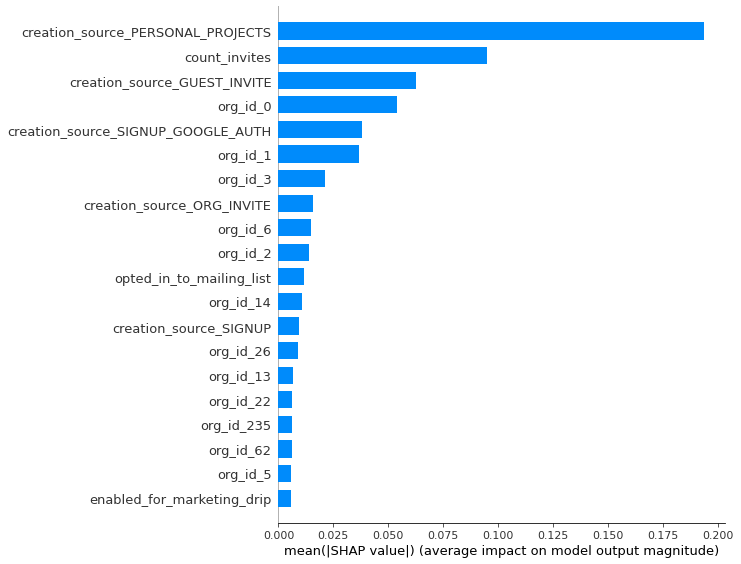

In [291]:
import shap

shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")